In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("symbol-vocab")
# mask_model = AutoModelForMaskedLM.from_pretrained("./symbol-masked-trainer/checkpoint-50000")
model = AutoModelForSequenceClassification.from_pretrained("./symbol-masked-trainer/checkpoint-50000", num_labels=2)
# model.bert = mask_model

OSError: ./symbol-masked-trainer/checkpoint-50000 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

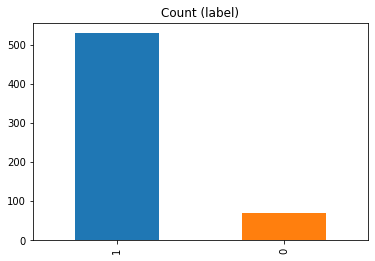

In [5]:
from glob import glob
from datasets import Dataset

import re
import pandas as pd

from parse import data_loading

data_url = '../crawler/stock/data/**.json'
url = glob(data_url)[-1]
data = data_loading(url)

data['label'].value_counts().plot(kind='bar', title='Count (label)', color=['#1f77b4', '#ff7f0e'])

dataset = Dataset.from_pandas(data.loc[:, ['label', 'sentense']])
dataset = dataset.remove_columns('__index_level_0__')

In [ ]:
def encode(example):
    sentense = example['sentense']

    result = tokenizer(
        sentense,
        padding='max_length',
        truncation=True,
    )
    return result

encoded_dataset = dataset.map(encode, batched=True)
encoded_dataset = encoded_dataset.train_test_split(test_size=0.2)
# print(encoded_dataset[0]['sentense'])
# print(encoded_dataset[0]['input_ids'])
# type(encoded_dataset[0]['labels'])

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

import numpy as np
import wandb

%env WANDB_PROJECT=Stocktwit_sentiment_analysis
training_args = TrainingArguments(
    output_dir="fin-bert-classifier-trainer",
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=5,
    save_steps=5000,
    per_device_train_batch_size=4,
    report_to="wandb",
    run_name="fin-bertweet-sentiment-classifier-test-5-epoch"
)

recall_metric = load_metric("recall")
precision_metric = load_metric("precision")
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    recall_result = recall_metric.compute(predictions=predictions, references=labels)
    precision_result = precision_metric.compute(predictions=predictions, references=labels)
    accuracy_result = accuracy_metric.compute(predictions=predictions, references=labels)
    return {**recall_result, **precision_result, **accuracy_result}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

wandb.finish()